### Изучение нейронных сетей. Лаб.3. Вычисление оптимальной скорости обучения.

#### LR Finder

cuda:0
Files already downloaded and verified
Files already downloaded and verified


/home/sbaykov/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


number_in_epoch = 1562
Learning rate = 1e-06


/home/sbaykov/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    20] loss: 2.310 lr: 0.0000011 
[1,    40] loss: 2.333 lr: 0.0000013 
[1,    60] loss: 2.312 lr: 0.0000014 
[1,    80] loss: 2.307 lr: 0.0000016 
[1,   100] loss: 2.299 lr: 0.0000018 
[1,   120] loss: 2.299 lr: 0.0000020 
[1,   140] loss: 2.305 lr: 0.0000023 
[1,   160] loss: 2.313 lr: 0.0000026 
[1,   180] loss: 2.292 lr: 0.0000029 
[1,   200] loss: 2.304 lr: 0.0000032 
[1,   220] loss: 2.318 lr: 0.0000036 
[1,   240] loss: 2.300 lr: 0.0000041 
[1,   260] loss: 2.293 lr: 0.0000046 
[1,   280] loss: 2.298 lr: 0.0000052 
[1,   300] loss: 2.303 lr: 0.0000058 
[1,   320] loss: 2.300 lr: 0.0000066 
[1,   340] loss: 2.318 lr: 0.0000074 
[1,   360] loss: 2.276 lr: 0.0000083 
[1,   380] loss: 2.297 lr: 0.0000093 
[1,   400] loss: 2.305 lr: 0.0000105 
[1,   420] loss: 2.311 lr: 0.0000118 
[1,   440] loss: 2.286 lr: 0.0000133 
[1,   460] loss: 2.329 lr: 0.0000150 
[1,   480] loss: 2.297 lr: 0.0000169 
[1,   500] loss: 2.310 lr: 0.0000190 
[1,   520] loss: 2.301 lr: 0.0000213 
[1,   540] l

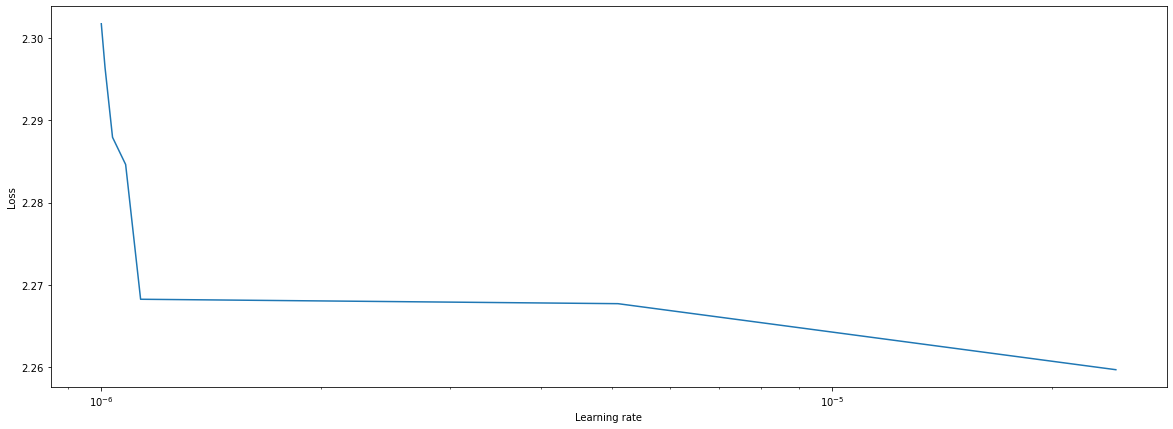

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np

# Проверка GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Компонуемые преобразования для наборов данных

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Если изображения разные - добавляют преобразование, например transforms.Resize((32,32))
# Можно применить нормализацию по параметрам из ImageNet (mean & std)
# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# mean - среднее отклонение
# std - стандартное отклонение

# mini-batches - мини-пакеты -
# batch_size=4 - размер пакета - сколько изображений пройдёт через сеть,
#                                прежде, чем мы обучим и обновим её

# Загрузчики

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Определение нейронной сети

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # Конструктор суперкласса
        
        # Описание слоёв:
        self.conv1 = nn.Conv2d(3, 6, 5)       #
        self.pool = nn.MaxPool2d(2, 2)        #
        self.conv2 = nn.Conv2d(6, 16, 5)      #
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Полносвязный слой
        self.fc2 = nn.Linear(120, 84)         # Полносвязный слой
        self.fc3 = nn.Linear(84, 10)          # Полносвязный слой

    # Функция, описывающая поток данных при обучении и предсказании
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)    # Преобразование в одномерный тензор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Определим функцию потерь и оптимизатор

criterion = nn.CrossEntropyLoss()  # Функция потерь. 
#Есть альтернативный вариант MSELoss

# Оптимизатор SGD - Стохастический градиентный оптимизатор. 
# Есть альтернативные варианты: AdaGrad, RMSProp, Adam

init_value=1e-6
final_value=1e-2
learn_rate = init_value

# Отправляем сеть на GPU

net.to(device)

# Обучение сети

start_time = time.time()

number_in_epoch = len(trainloader) - 1

print('number_in_epoch =', number_in_epoch)
update_step = (final_value / init_value) ** (1 / number_in_epoch)
best_loss = 0.0
batch_num = 0
losses = []
log_lrs = []

for epoch in range(1):  # loop over the dataset multiple times

    print("Learning rate =", learn_rate)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer = optim.SGD(net.parameters(), lr=learn_rate, momentum=0.9)
        
        batch_num += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((learn_rate))

            
        # print statistics
        #running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches

#            print('[%d, %5d] loss: %.3f lr: %.7f ' %
#                  (epoch + 1, i + 1, running_loss / 20, learn_rate))
            print('[%d, %5d] loss: %.3f lr: %.7f ' %
                  (epoch + 1, i + 1, loss.item(), learn_rate))
            #running_loss = 0.0

        # Update the lr for the next step and store

        learn_rate *= update_step
        
            
print('Finished Training')

print("Working time: %s seconds" % (time.time() - start_time))

print('Зависимость ошибки от скорости обучения:')

plt.figure(figsize=(20, 7))
plt.plot(log_lrs, losses)
#plt.plot(log_lrs[10:-5], losses[10:-5])
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()